<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/gimseng/99-ML-Learning-Projects/blob/master/002/solution/linear_regression.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Hi - Welcome to the Lasso Regression excercise

## This notebook is based on the Linear Regression notebook

## The main task of the assignment is in the second half of the notebook

### Run cells below which import all required libraries

In [182]:
import numpy as np
import pandas as pd
import sklearn, sklearn.model_selection
import matplotlib.pyplot as plt

### The cell below retreives the data and splits it into train_x, train_y, valid_x, valid_y, test_x, test_y

In [183]:
# pick how big the validation/test portion of the data is, currently set to 20% validation, 20% test, and 60% train
valid_size = 0.2
test_size = 0.2

# load the data from the .csv file
github_url = 'https://raw.githubusercontent.com/gimseng/99-ML-Learning-Projects/'
data_source = 'master/002/data/housing_prices.csv'
data = pd.read_csv(github_url+data_source)

def train_valid_test_split(data, valid_size, test_size):
    # split into train and test
    train, test = sklearn.model_selection.train_test_split(data, test_size=test_size)
    # further split train into train and validation. (valid_size needs to be recalculated to properly split train)
    valid_size = valid_size/(1-test_size)
    train, valid = sklearn.model_selection.train_test_split(train, test_size=valid_size)
    return train, valid, test

train, valid, test = train_valid_test_split(data, valid_size, test_size)
train_x, train_y = train.iloc[:, :-1], train.iloc[:, -1:]
valid_x, valid_y = valid.iloc[:, :-1], valid.iloc[:, -1:]
test_x, test_y = test.iloc[:, :-1], test.iloc[:, -1:]

print(f'train size: {len(train_x)}, valid size: {len(valid_x)}, test size: {len(test_x)}')

train size: 876, valid size: 292, test size: 292


### The cell below helps us view a few of our data points and also view how the selling price varies for different features

In [184]:
data.head(10)

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   
5   6          50       RL         85.0    14115   Pave   NaN      IR1   
6   7          20       RL         75.0    10084   Pave   NaN      Reg   
7   8          60       RL          NaN    10382   Pave   NaN      IR1   
8   9          50       RM         51.0     6120   Pave   NaN      Reg   
9  10         190       RL         50.0     7420   Pave   NaN      Reg   

  LandContour Utilities  ... PoolArea PoolQC  Fence MiscFeature MiscVal  \
0         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
1         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
2         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
3         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
4         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
5         Lvl    AllPub  ...        0    NaN  MnPrv        Shed     700   
6         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
7         Lvl    AllPub  ...        0    NaN    NaN        Shed     350   
8         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   
9         Lvl    AllPub  ...        0    NaN    NaN         NaN       0   

  MoSold YrSold  SaleType  SaleCondition  SalePrice  
0      2   2008        WD         Normal     208500  
1      5   2007        WD         Normal     181500  
2      9   2008        WD         Normal     223500  
3      2   2006        WD        Abnorml     140000  
4     12   2008        WD         Normal     250000  
5     10   2009        WD         Normal     143000  
6      8   2007        WD         Normal     307000  
7     11   2009        WD         Normal     200000  
8      4   2008        WD        Abnorml     129900  
9      1   2008        WD         Normal     118000  

[10 rows x 81 columns]

<AxesSubplot:xlabel='Garage car room', ylabel='Sale Price'>

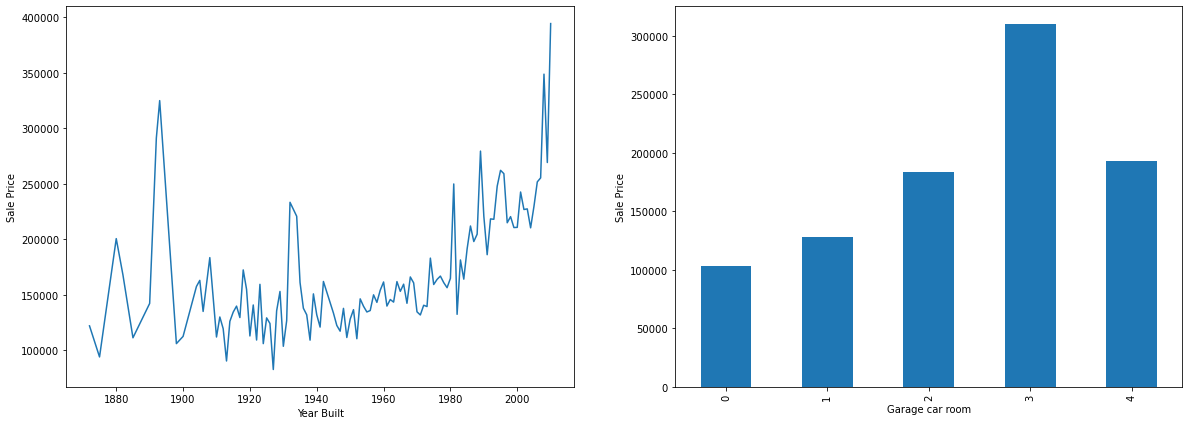

In [185]:
fig, axes = plt.subplots(nrows=1, ncols=2)
fig=(20,7)
data.groupby('YearBuilt').mean()['SalePrice'].plot(ylabel='Sale Price',xlabel='Year Built',ax=axes[0],figsize=fig)
data.groupby('GarageCars').mean()['SalePrice'].plot(kind='bar',ylabel='Sale Price',xlabel='Garage car room',ax=axes[1],figsize=fig)

### The cell below scales the numeric features using a min_max_scaler (scales them between 0 and 1)

In [186]:
numeric_columns = train_x.select_dtypes(include='number').columns
# scaler = sklearn.preprocessing.MinMaxScaler()
# scaler = sklearn.preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal')
scaler = sklearn.preprocessing.StandardScaler()
# train on concatenation of train and validation
scaler.fit(pd.concat((train_x[numeric_columns], valid_x[numeric_columns])))
# apply on all data
train_x[numeric_columns] = scaler.transform(train_x[numeric_columns])
valid_x[numeric_columns] = scaler.transform(valid_x[numeric_columns])
test_x[numeric_columns] = scaler.transform(test_x[numeric_columns])


### The cell below one-hot encodes the data

In [187]:
def get_dummies_column_keys(dataFrames):
    '''returns a column list of get dummies for concatenated dataframes'''
    return pd.get_dummies(pd.concat(dataFrames)).columns.tolist()

def get_dummies_using_keys(dataFrame, column_keys):
    '''returns get dummies result with columns matching column_keys'''
    result = pd.get_dummies(dataFrame)
    result = result.reindex(columns=column_keys).fillna(0.00)
    return result

# get the keys for the concatenation of all datasets 
column_keys = get_dummies_column_keys((train_x, valid_x, test_x))
train_x = get_dummies_using_keys(train_x, column_keys)
valid_x = get_dummies_using_keys(valid_x, column_keys)
test_x = get_dummies_using_keys(test_x, column_keys)

### The cell below appends a '1' to all rows by adding a 'Bias' feature with the value of 1 for all rows<br/> This is to simulate a bias without adding any bias functionality to the Linear Regression algorithm 

In [188]:
train_x['Bias'] = 1
valid_x['Bias'] = 1
test_x['Bias'] = 1

### This last cell gets the numpy arrays that we will work on from the panda dataframes

In [189]:
# store the dataframes in df_* variables
df_train_x, df_train_y = train_x, train_y
df_valid_x, df_valid_y = valid_x, valid_y
df_test_x, df_test_y = test_x, test_y

# store the numpy arrays in the regular variables
train_x, train_y = train_x.values, train_y.values
valid_x, valid_y = valid_x.values, valid_y.values
test_x, test_y = test_x.values, test_y.values

# Proceed with any data analysis in the next cell

## (Optional but encouraged)

# This is the main task of the exercise

## You need to implement the following functions which <br/> implement Linear Regression and all it's required functions

### The first major function is the 'predict' function <br/> Remember the Linear Regression equation is
$$\hat{Y} = w_0 + w_1 x_1 + w_2 x_2 + ... + w_m x_m$$

### hint: try to implement a 'vectorized' version by using a matrix multiplication<br/> which will massively increase performance

In [190]:

def predict(w, x):
    '''
    Return the linear regression prediction from the weights and input features
    Args:
        w: The weight vector, shape: (features, 1)
        x: The input data, shape: (num_samples, features)
    Returns:
        The prediction of the model, shape: (num_samples, 1)
    '''
    ### YOUR CODE HERE
#     raise NotImplementedError
    return x.dot(w)

def init_weights(x):
    '''
    Initialize the weights vector, the data is passed in to know how many weights you need
    Args:
        x: The input data, shape: (num_samples, features)
    Returns:
        The initial weight vector of random values, shape: (features, 1)
    '''
    ### YOUR CODE HERE
#     raise NotImplementedError
#     rv = np.zeros((x.shape[1], 1)) 
    return np.random.randn(x.shape[1], 1)/np.sqrt(x.shape[1])

### Next you have to implement the Mean Squared Error Loss calculation following the following formula 
$$LOSS(W)=\frac{1}{2n} \sum_{i=1}^{n} (\hat{y}_i-y_i)^2$$

In [191]:
def loss(y_hat, y):
    '''
    Calculate the Mean Squared Error based on the y_hat (the predicted value) and y (the true values)
    Args:
        y_hat: the predicted values of the input, shape: (num_samples, 1)
        y: the true values of the input, shape: (num_samples, 1)
    Returns:
        Mean Squared Error, shape: Scaler
    '''
    ### YOUR CODE HERE
#     raise NotImplementedError
    n = y.shape[0]
    delta = y_hat - y
    return ((delta.T @ delta) / (2*n))

### Next you have to implement the gradient calculation for the weights accoarding to the formula

$$\frac{\partial LOSS(W)}{\partial W_j} 
= \sum_{i=1}^{n} (2*(\hat{y}_i-y_i)*x_{i,j} + \eta * \frac{\lvert{\partial W_j}\lvert}{\partial W_j})$$

In [192]:
def get_gradient(w, x, y_hat, y, l1_coeff):
    '''
    Get the gradient of the weights using the parameters passed 
    (Note: not all parameters passed have to be used)
    Args:
        w: The weight vector, shape: (features, 1)
        x: The input data, shape: (num_samples, features)
        y_hat: the predicted values of the input, shape: (num_samples, 1)
        y: the true values of the input, shape: (num_samples, 1)
        l1_coeff: L1 regularization coefficient
    Returns:
        The gradients of the weight vector, shape: (features, 1)
    '''
    ### YOUR CODE HERE
#     raise NotImplementedError
# https://towardsdatascience.com/intuitions-on-l1-and-l2-regularisation-235f2db4c261
    n = y.shape[0]
    delta = y_hat - y
    dW = ( (2 * x.T.dot(delta) ) + np.sign(w) * l1_coeff ) / n
    return dW

### Next you have to implement the gradient descent update for the weights accoarding to the formula

$$w_j:=w_j - \alpha * \frac{\partial LOSS(W)}{\partial W_j} $$

In [193]:
def get_updated_weights(w, w_gradients, learning_rate):
    '''
    Calculate the new value of the weights after applying the gradient descent weight update rule 
    Args:
        w: The weight vector, shape: (features, 1)
        w_gradients: The gradients of the weight vector, shape: (features, 1)
        learning_rate: The learning rate of the algorithm, shape: Scaler
    Returns:
        The updated value of the weights, shape: (features, 1)
    '''
    ### YOUR CODE HERE
#     raise NotImplementedError
    return w - learning_rate * w_gradients

### Finally implement the training loop, this should simply be<br/> a loop that calls the functions you implemented above

In [194]:
def train(epochs, x, y, learning_rate=1e-3, initial_weights=None, l1_coeff=0, initial_b=0):
    '''
    The main train loop for the algorithm. This performs the gradient update step 'epochs' times.
    Args:
        x: The input data, shape: (num_samples, features)
        y: the true values of the input, shape: (num_samples, 1)
        learning_rate: The learning rate of the algorithm, shape: Scaler
        initial_weights: The initial weight to start training, this should be passed to continue training
    Returns:
        The final weight values after applying 'epochs' number of updates on 'initial_weights', shape: (features, 1)
    '''
    if initial_weights is None:
        weight = init_weights(x)
    else:
        weight = initial_weights
    
    for epoch in range(epochs):
        ### YOUR CODE HERE
#         raise NotImplementedError
        y_hat = predict(weight, train_x).reshape(-1, 1)
        
        delta = y_hat - y

        dW = get_gradient(weight, x, y_hat, y, l1_coeff)
#         dW = ( -(2 * x.T.dot(-delta) ) + np.sign(weight) * l1_coeff ) / x.shape[0]
        weight = get_updated_weights(weight, dW, learning_rate)
#         weight = weight - learning_rate * dW
        
        delta = delta.reshape(-1)
        meanSquareError = delta.dot(delta)/x.shape[1] # Capture MSE - and?

    return weight


### The cell below will run your code

### After 200,000 epochs our results were the following: 
### Train loss:1.9036887e+08<br/> Valid loss: 4.7176443e+08<br/> Test loss: 1.08308357e+09

In [195]:
%%time
w = None
weights=[]
l1_coeff = .0001
for i in range(20):
    w = train(10000, train_x, train_y, learning_rate=5e-3, l1_coeff=l1_coeff, initial_weights=w)
    weights.append(w)
    print('epoch:', (i+1)*10000, end='   ')
    print('Train loss:', loss(predict(w, train_x), train_y), end='   ')
    print('Valid loss:', loss(predict(w, valid_x), valid_y))
print('Final Model -- Test loss:', loss(predict(w, test_x), test_y))

epoch: 10000   Train loss: [[2.4804421e+08]]   Valid loss: [[3.34900642e+08]]
epoch: 20000   Train loss: [[2.27315727e+08]]   Valid loss: [[3.5796312e+08]]
epoch: 30000   Train loss: [[2.16517742e+08]]   Valid loss: [[3.72254317e+08]]
epoch: 40000   Train loss: [[2.09689841e+08]]   Valid loss: [[3.83888202e+08]]
epoch: 50000   Train loss: [[2.05042711e+08]]   Valid loss: [[3.94172634e+08]]
epoch: 60000   Train loss: [[2.01730763e+08]]   Valid loss: [[4.03437126e+08]]
epoch: 70000   Train loss: [[1.99288268e+08]]   Valid loss: [[4.11812646e+08]]
epoch: 80000   Train loss: [[1.97437495e+08]]   Valid loss: [[4.19391221e+08]]
epoch: 90000   Train loss: [[1.96003669e+08]]   Valid loss: [[4.26255866e+08]]
epoch: 100000   Train loss: [[1.94872149e+08]]   Valid loss: [[4.32483734e+08]]
epoch: 110000   Train loss: [[1.93965135e+08]]   Valid loss: [[4.3814508e+08]]
epoch: 120000   Train loss: [[1.93228301e+08]]   Valid loss: [[4.43302553e+08]]
epoch: 130000   Train loss: [[1.92622764e+08]]   Val

### The cell below shows us how the prediction improves while training over the span of 200,000 epochs ( By steps of 10000 epochs)

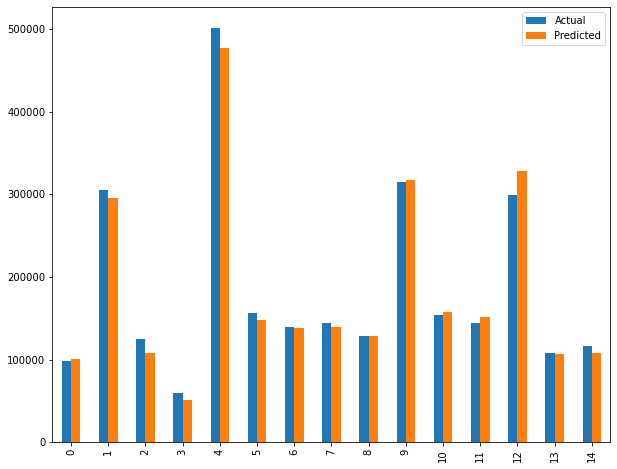

In [196]:
import IPython
for w in weights:   
    IPython.display.clear_output(wait=True)
    pd.DataFrame({'Actual': train_y.flatten(), 'Predicted': predict(w,train_x).flatten()}).head(15).plot(kind='bar',figsize=(10,8))
    plt.show()